<a href="https://colab.research.google.com/github/beaulima/GAN/blob/main/caffe_ml_Transformers_Image_GPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
%matplotlib inline
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#Application Image GPT with [Transformers](https://github.com/huggingface/transformers)

https://openai.com/blog/image-gpt/

https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf

*The Illustrated GPT-2 (Visualizing Transformer Language Models)*
http://jalammar.github.io/illustrated-gpt2/#:~:text=One%20Difference%20From%20BERT,-First%20Law%20of&text=The%20GPT%2D2%20is%20built,one%20token%20at%20a%20time.


#GPT-2


* Le GPT-2 est un modèle de langage générateur de phrases qui a été développé par OpenAI en 2019.
* Un des événements les plus marquants du ML en 2019.
* GPT-2 et BERT sont deux principaux modèles de langage (2020).
* Ils sont identiques dans la mesure où ils sont tous deux basés sur l'architecture du transformateur
* Ils sont différents dans la mesure où BERT n'a que les blocs codeurs du transformateur, et GPT-2 n'a que les blocs décodeurs du transformateur.
* Le GPT-2 fonctionne comme un modèle de langage traditionnel, c'est-à-dire qu'il prend les vecteurs de mots et les entrées et produit des estimations de la probabilité du mot suivant comme sorties. Il est auto-régressif par nature : chaque *token* de la phrase a le contexte des mots précédents. 
* Le GPT-2 fonctionne un *token* à la fois. 
* BERT n'est pas auto-régressif. Il utilise tout le contexte environnant de la phrase
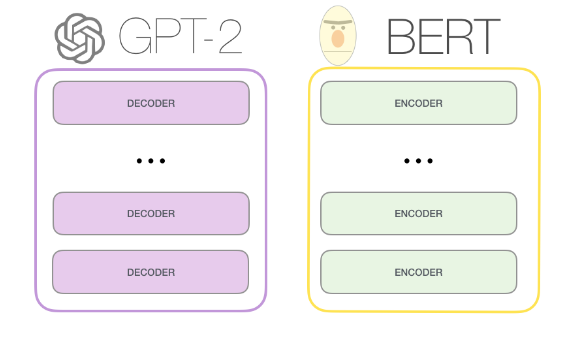




# Détails sur l'architecture¶



* Une copie conforme de l'architecture de base du transformateur.

* Il est constitué uniquement de blocs de décodeurs empilés provenant de l'architecture du transformateur. 

* Dans le GPT-2, l'auto-attention masquée est utilisée: le décodeur est seulement autorisé (via le masquage des positions restantes des mots) à observer des informations à partir des mots précédents dans la phrase (plus le mot lui-même).

* Le GPT-2 est entrainé su la tâche standard : étant donné une séquence de mots précédents, prédire le mot suivant.

* Il y aussi un encodage du vector: (hashing)

# Overview de l'approche pour les images

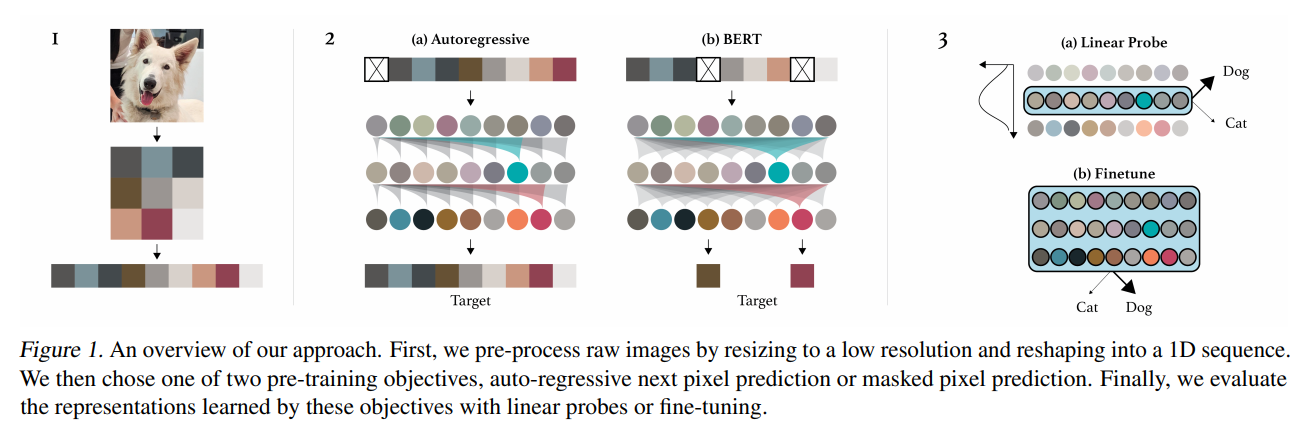

# Téléchargement du code Image GPT

In [13]:
!git clone https://github.com/openai/image-gpt.git

fatal: destination path 'image-gpt' already exists and is not an empty directory.


In [14]:
model_sizes = ["s", "m", "l"] #small medium large, xl not available
model_size = "s"
models_dir = "/content/models"
color_clusters_dir = "/content/clusters"
# number of inputs
bs = 8 
# image 32x32
n_px = 48

In [15]:
!python image-gpt/download.py --model {model_size} --ckpt 1000000 --clusters --download_dir {models_dir}/{model_size}
!python image-gpt/download.py --clusters --download_dir {color_clusters_dir}

input args:
 {
    "download_dir":"/content/models/s",
    "bert":false,
    "model":"s",
    "ckpt":"1000000",
    "clusters":true,
    "dataset":null
}
Fetching model.ckpt-1000000.data-00000-of-00032: 1.00kit [00:00, 889kit/s]      
Fetching model.ckpt-1000000.data-00001-of-00032: 31.5Mit [00:07, 3.95Mit/s]     
Fetching model.ckpt-1000000.data-00002-of-00032: 28.3Mit [00:07, 3.70Mit/s]     
Fetching model.ckpt-1000000.data-00003-of-00032: 28.3Mit [00:06, 4.14Mit/s]     
Fetching model.ckpt-1000000.data-00004-of-00032: 28.3Mit [00:07, 3.75Mit/s]     
Fetching model.ckpt-1000000.data-00005-of-00032: 31.5Mit [00:07, 4.36Mit/s]     
Fetching model.ckpt-1000000.data-00006-of-00032: 30.4Mit [00:07, 4.21Mit/s]     
Fetching model.ckpt-1000000.data-00007-of-00032: 28.3Mit [00:07, 3.90Mit/s]     
Fetching model.ckpt-1000000.data-00008-of-00032: 31.5Mit [00:07, 4.10Mit/s]     
Fetching model.ckpt-1000000.data-00009-of-00032: 29.4Mit [00:07, 3.69Mit/s]     
Fetching model.ckpt-1000000.data-000

# Overview de l'approche

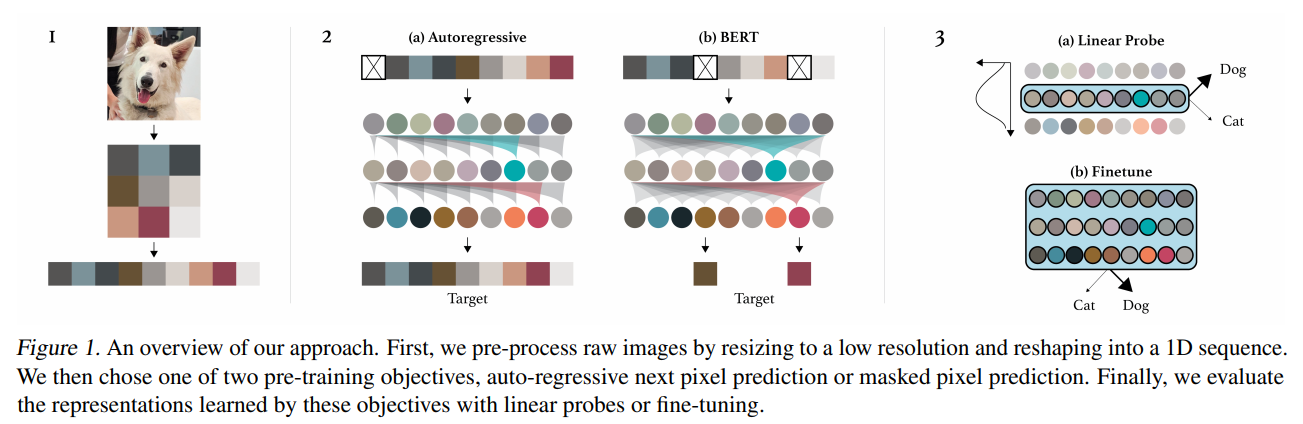


# Utilisation de GPT2LMHeadModel


In [ ]:
!pip install transformers

In [ ]:
import torch
import numpy as np
def set_all_seeds(seeds = 42):
  torch.manual_seed(seeds)
  np.random.seed(seeds)
  torch.set_deterministic(True)

set_all_seeds()

In [ ]:
import os
import transformers
from transformers.models.gpt2.modeling_gpt2 import GPT2Model,GPT2LMHeadModel
import torch
import torch.nn as nn
import logging
logger = logging.getLogger(__name__)

def load_tf_weights_in_image_gpt2(model, config, gpt2_checkpoint_path):
    """ Load tf checkpoints in a pytorch model
    """
    try:
        import re
        import tensorflow as tf
    except ImportError:
        logger.error(
            "Loading a TensorFlow model in PyTorch, requires TensorFlow to be installed. Please see "
            "https://www.tensorflow.org/install/ for installation instructions."
        )
        raise
    tf_path = os.path.abspath(gpt2_checkpoint_path)
    logger.info("Converting TensorFlow checkpoint from {}".format(tf_path))
    # Load weights from TF model
    init_vars = tf.train.list_variables(tf_path)
    names = []
    arrays = []

    for name, shape in init_vars:
        logger.info("Loading TF weight {} with shape {}".format(name, shape))
        array = tf.train.load_variable(tf_path, name)
        names.append(name)
        arrays.append(array.squeeze())

    for name, array in zip(names, arrays):
        name = name[6:]  # skip "model/"
        name = name.split("/")

        # adam_v and adam_m are variables used in AdamWeightDecayOptimizer to calculated m and v
        # which are not required for using pretrained model
        if any(
            n in ["adam_v", "adam_m", "AdamWeightDecayOptimizer", "AdamWeightDecayOptimizer_1", "global_step"]
            for n in name
        ) or name[-1] in ['_step']:
            logger.info("Skipping {}".format("/".join(name)))
            continue
        
        pointer = model
        if name[-1] not in ["wtet"]:
          pointer = getattr(pointer, "transformer")
        
        for m_name in name:
            if re.fullmatch(r"[A-Za-z]+\d+", m_name):
                scope_names = re.split(r"(\d+)", m_name)
            else:
                scope_names = [m_name]

            if scope_names[0] == "w" or scope_names[0] == "g":
                pointer = getattr(pointer, "weight")
            elif scope_names[0] == "b":
                pointer = getattr(pointer, "bias")
            elif scope_names[0] == "wpe" or scope_names[0] == "wte":
                pointer = getattr(pointer, scope_names[0])
                pointer = getattr(pointer, "weight")
            elif scope_names[0] in ['q_proj','k_proj','v_proj']:
                pointer = getattr(pointer, 'c_attn')
                pointer = getattr(pointer, 'weight')
            elif len(name) ==3 and name[1]=="attn" and scope_names[0]=="c_proj":
                pointer = getattr(pointer, scope_names[0])
                pointer = getattr(pointer, 'weight')
            elif scope_names[0]=="wtet":
                pointer = getattr(pointer, "lm_head")
                pointer = getattr(pointer, 'weight')
            elif scope_names[0]=="sos":
                pointer = getattr(pointer,"wte")
                pointer = getattr(pointer, 'weight')
            else:
                pointer = getattr(pointer, scope_names[0])
            if len(scope_names) >= 2:
                num = int(scope_names[1])
                pointer = pointer[num]

        if len(name) > 1 and name[1]=="attn" or name[-1]=="wtet" or name[-1]=="sos" or name[-1]=="wte":
           pass #array is used to initialize only part of the pointer so sizes won't match
        else:
          try:
              assert pointer.shape == array.shape
          except AssertionError as e:
              e.args += (pointer.shape, array.shape)
              raise
          
        logger.info("Initialize PyTorch weight {}".format(name))

        if name[-1]=="q_proj":
          pointer.data[:,:config.n_embd] = torch.from_numpy(array.reshape(config.n_embd,config.n_embd) ).T
        elif name[-1]=="k_proj":
          pointer.data[:,config.n_embd:2*config.n_embd] = torch.from_numpy(array.reshape(config.n_embd,config.n_embd) ).T
        elif name[-1]=="v_proj":
          pointer.data[:,2*config.n_embd:] = torch.from_numpy(array.reshape(config.n_embd,config.n_embd) ).T
        elif (len(name) ==3 and name[1]=="attn" and name[2]=="c_proj" ):
          pointer.data = torch.from_numpy(array.reshape(config.n_embd,config.n_embd) )
        elif name[-1]=="wtet":
          pointer.data = torch.from_numpy(array)
        elif name[-1]=="wte":
          pointer.data[:config.vocab_size-1,:] = torch.from_numpy(array)
        elif name[-1]=="sos":
          pointer.data[-1] = torch.from_numpy(array)
        else:
          pointer.data = torch.from_numpy(array)

    return model


from torch.nn.parameter import Parameter
class ln_mod(nn.Module):
    def __init__(self, nx,eps=1e-5):
        super().__init__()
        self.eps = eps
        self.weight = Parameter(torch.Tensor(nx))
    def forward(self,x):#input is not mean centered
        return x / torch.sqrt( torch.std(x,axis=-1,unbiased=False,keepdim=True)**2 + self.eps ) * self.weight.data[...,:] 

def replace_ln(m, name,config):
  for attr_str in dir(m):
      target_attr = getattr(m, attr_str)
      if type(target_attr) == torch.nn.LayerNorm:
          #print('replaced: ', name, attr_str)
          setattr(m, attr_str, ln_mod(config.n_embd,config.layer_norm_epsilon))

  for n, ch in m.named_children():
      replace_ln(ch, n,config)        

def gelu2(x):
    return x * torch.sigmoid(1.702 * x)

class ImageGPT2LMHeadModel(GPT2LMHeadModel):
  load_tf_weights = load_tf_weights_in_image_gpt2
  
  def __init__(self, config):
      super().__init__(config)
      self.lm_head = nn.Linear(config.n_embd, config.vocab_size - 1, bias=False)
      replace_ln(self,"net",config) #replace layer normalization
      for n in range(config.n_layer):
        self.transformer.h[n].mlp.act = gelu2 #replace activation 

  def tie_weights(self): #image-gpt doesn't tie output and input embeddings
    pass 

# Unconditional Image Generation

In [ ]:
import numpy as np
color_clusters_file = "%s/kmeans_centers.npy"%(color_clusters_dir)
clusters = np.load(color_clusters_file) #get color clusters

In [ ]:
MODELS={"l":(1536,16,48),"m":(1024,8,36),"s":(512,8,24) } 
n_embd,n_head,n_layer=MODELS[model_size] #set model hyperparameters
vocab_size = len(clusters) + 1 #add one for start of sentence token
config = transformers.GPT2Config(vocab_size=vocab_size,n_ctx=n_px*n_px,n_positions=n_px*n_px,n_embd=n_embd,n_layer=n_layer,n_head=n_head)
model_path = "%s/%s/model.ckpt-1000000.index"%(models_dir,model_size)

model = ImageGPT2LMHeadModel.from_pretrained(model_path,from_tf=True,config=config).cuda()

In [ ]:
print(model)

ImageGPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(513, 512)
    (wpe): Embedding(1024, 512)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): ln_mod()
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): ln_mod()
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): ln_mod()
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): ln_mod()
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
context = np.full( (bs,1), vocab_size - 1 ) #initialize with SOS token
context = torch.tensor(context).cuda()
output = model.generate(input_ids=context,max_length= n_px*n_px + 1,temperature=1.0,do_sample=True,top_k=40)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


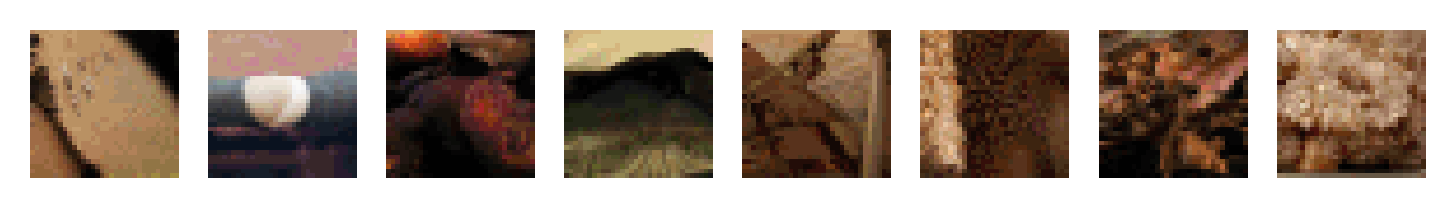

In [ ]:
#visualize samples with Image-GPT color palette.
%matplotlib inline
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

samples = output[:,1:].cpu().detach().numpy()
samples_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [n_px, n_px, 3]).astype(np.uint8) for s in samples] # convert color cluster tokens back to pixels
f, axes = plt.subplots(1,bs,dpi=300)

for img,ax in zip(samples_img,axes):
    ax.axis('off')
    ax.imshow(img)
    

# Tokenize Cropped Images for Image Completion

In [ ]:
#numpy implementation of functions in image-gpt/src/utils which convert pixels of image to nearest color cluster. 
def normalize_img(img):
  return img/127.5 - 1

def squared_euclidean_distance_np(a,b):
  b = b.T
  a2 = np.sum(np.square(a),axis=1)
  b2 = np.sum(np.square(b),axis=0)
  ab = np.matmul(a,b)
  d = a2[:,None] - 2*ab + b2[None,:]
  return d

def color_quantize_np(x, clusters):
    x = x.reshape(-1, 3)
    d = squared_euclidean_distance_np(x, clusters)
    return np.argmin(d,axis=1)

In [ ]:
#get images
!curl https://www.crim.ca/wp-content/uploads/2020/10/Houman_Zolfaghani.jpg > sg.jpeg
image_paths = ["sg.jpeg"]*bs

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 19828  100 19828    0     0   197k      0 --:--:-- --:--:-- --:--:--  199k


In [ ]:
#Resize original images to n_px by n_px
import cv2
import numpy as np
dim=(n_px,n_px)

x = np.zeros((bs,n_px,n_px,3),dtype=np.uint8)

for n,image_path in enumerate(image_paths):
  img_np = cv2.imread(image_path)   # reads an image in the BGR format
  img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)   # BGR -> RGB
  H,W,C = img_np.shape
  D = min(H,W)
  img_np = img_np[:D,:D,:C] #get square piece of image
  x[n] = cv2.resize(img_np,dim, interpolation = cv2.INTER_AREA) #resize to n_px by n_px
  

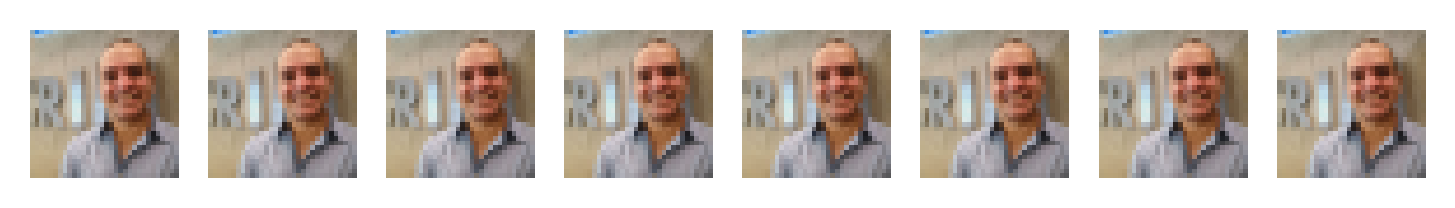

In [ ]:
#visualize resized images
f, axes = plt.subplots(1,bs,dpi=300)

for img,ax in zip(x,axes):
    ax.axis('off')
    ax.imshow(img)

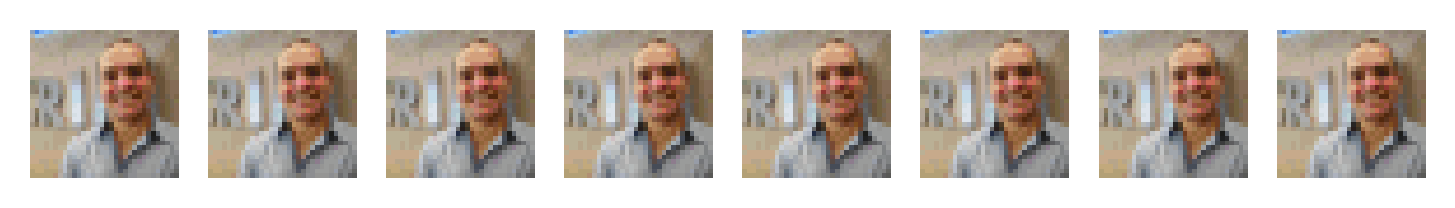

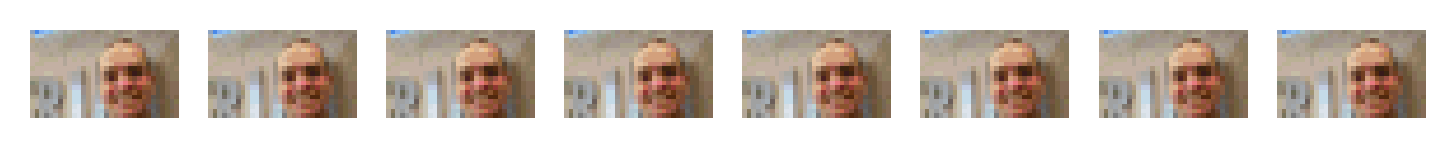

In [ ]:
#use Image-GPT color palette and crop images
x_norm = normalize_img(x) #normalize pixels values to -1 to +1
samples = color_quantize_np(x_norm,clusters).reshape(x_norm.shape[:-1]) #map pixels to closest color cluster

n_px_crop = 19
primers = samples.reshape(-1,n_px*n_px)[:,:n_px_crop*n_px] # crop top n_px_crop rows. These will be the conditioning tokens

#visualize samples and crops with Image-GPT color palette. Should look similar to original resized images
samples_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [n_px, n_px, 3]).astype(np.uint8) for s in samples] # convert color clusters back to pixels
primers_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [n_px_crop,n_px, 3]).astype(np.uint8) for s in primers] # convert color clusters back to pixels


f, axes = plt.subplots(1,bs,dpi=300)
for img,ax in zip(samples_img,axes):
    ax.axis('off')
    ax.imshow(img)

f, axes2 = plt.subplots(1,bs,dpi=300)
for img,ax in zip(primers_img,axes2):
    ax.axis('off')
    ax.imshow(img)

# Conditional Image Completion

In [ ]:
context = np.concatenate( (np.full( (bs,1), vocab_size - 1 ),primers,), axis=1 )
print(context)
print(context.shape)
context = torch.tensor(context).cuda()
output = model.generate(input_ids=context,max_length= n_px*n_px + 1,temperature=1.0,do_sample=True,top_k=50)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[[ 16 200 257 ... 485 373 379]
 [ 16 200 257 ... 485 373 379]
 [ 16 200 257 ... 485 373 379]
 ...
 [ 16 200 257 ... 485 373 379]
 [ 16 200 257 ... 485 373 379]
 [ 16 200 257 ... 485 373 379]]
(8, 609)


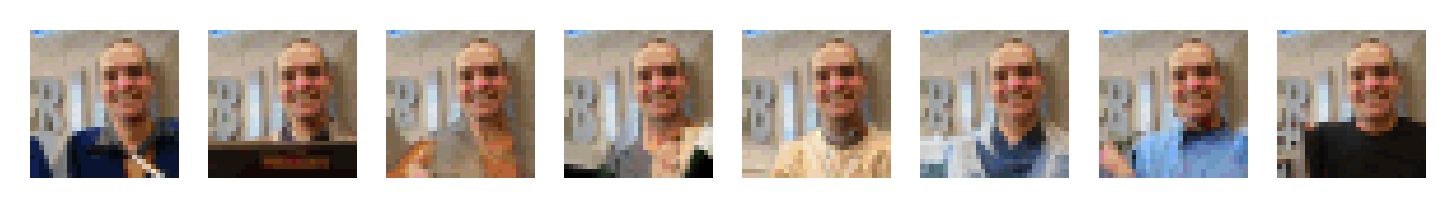

In [ ]:
#visualize samples with Image-GPT color palette. 

samples = output[:,1:].cpu().detach().numpy()
samples_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [n_px, n_px, 3]).astype(np.uint8) for s in samples] # convert color cluster tokens back to pixels
f, axes = plt.subplots(1,bs,dpi=300)

for img,ax in zip(samples_img,axes):
    ax.axis('off')
    ax.imshow(img)
    

# Strike Again

In [ ]:
#Resize original images to n_px by n_px
import cv2
import numpy as np
dim=(n_px,n_px)

def image_gpt_process(x, ntimes=2, use_this_image=None,  n_px_crop = 16):

  #use Image-GPT color palette and crop images
  x_norm = normalize_img(x) #normalize pixels values to -1 to +1
  samples = color_quantize_np(x_norm,clusters).reshape(x_norm.shape[:-1]) #map pixels to closest color cluster

 
  primers = samples.reshape(-1,n_px*n_px)[:,:n_px_crop*n_px] # crop top n_px_crop rows. These will be the conditioning tokens

  #visualize samples and crops with Image-GPT color palette. Should look similar to original resized images
  samples_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [n_px, n_px, 3]).astype(np.uint8) for s in samples] # convert color clusters back to pixels
  primers_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [n_px_crop,n_px, 3]).astype(np.uint8) for s in primers] # convert color clusters back to pixels


  f, axes = plt.subplots(1,bs,dpi=300)
  for img,ax in zip(samples_img,axes):
      ax.axis('off')
      ax.imshow(img)

  f, axes2 = plt.subplots(1,bs,dpi=300)
  for img,ax in zip(primers_img,axes2):
      ax.axis('off')
      ax.imshow(img)

  context = np.concatenate( (np.full( (bs,1), vocab_size - 1 ),primers,), axis=1 )
  context = torch.tensor(context).cuda()

  for k in  range(ntimes):
    output = model.generate(input_ids=context,max_length= n_px*n_px + 1,temperature=1.0,do_sample=True,top_k=40)

    #visualize samples with Image-GPT color palette. 

    samples = output[:,1:].cpu().detach().numpy()
    samples_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [n_px, n_px, 3]).astype(np.uint8) for s in samples] # convert color cluster tokens back to pixels
    f, axes = plt.subplots(1,bs,dpi=300)

    for img,ax in zip(samples_img,axes):
        ax.axis('off')
        ax.imshow(img)




In [ ]:
#get images
!curl https://d1hbpr09pwz0sk.cloudfront.net/profile_pic/martin-sotir-bdc05709 > ms.jpeg
!curl https://www.crim.ca/wp-content/uploads/2020/10/Houman_Zolfaghani.jpg  > hz.jpeg
image_paths = ["ms.jpeg"]*bs

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4800  100  4800    0     0    99k      0 --:--:-- --:--:-- --:--:--   99k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 19828  100 19828    0     0   129k      0 --:--:-- --:--:-- --:--:--  129k


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


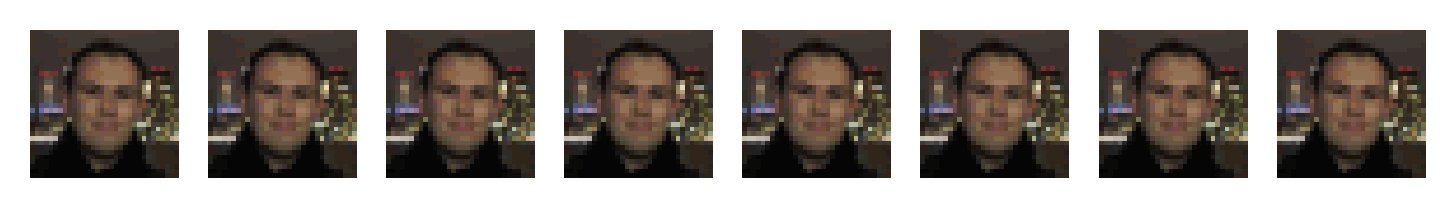

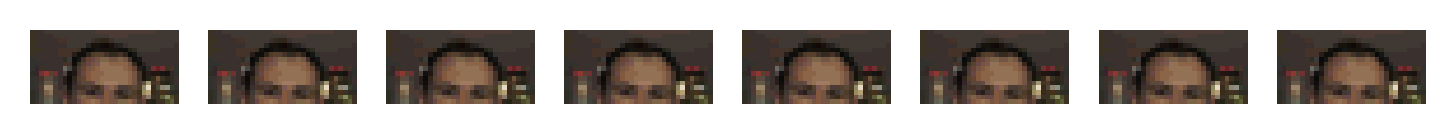

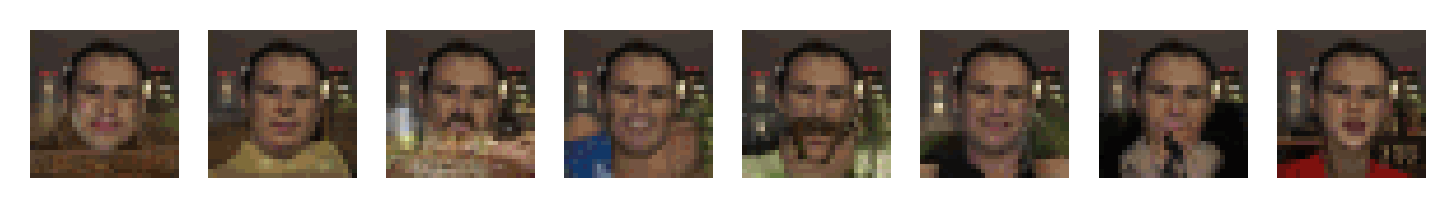

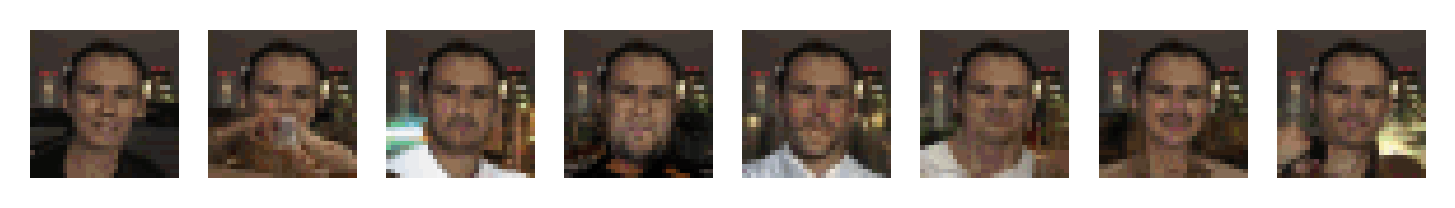

In [ ]:
  x = np.zeros((bs,n_px,n_px,3),dtype=np.uint8)

  for n,image_path in enumerate(image_paths):
    img_np = cv2.imread(image_path)   # reads an image in the BGR format
    img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)   # BGR -> RGB
    H,W,C = img_np.shape
    D = min(H,W)
    img_np = img_np[:D,:D,:C] #get square piece of image
    x[n] = cv2.resize(img_np,dim, interpolation = cv2.INTER_AREA) #resize to n_px by n_px

image_gpt_process(x, ntimes=2)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


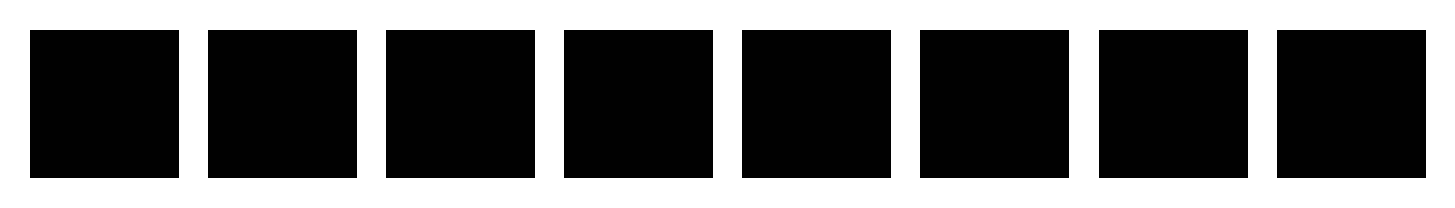

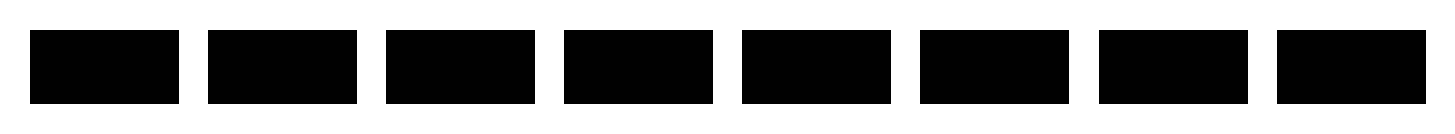

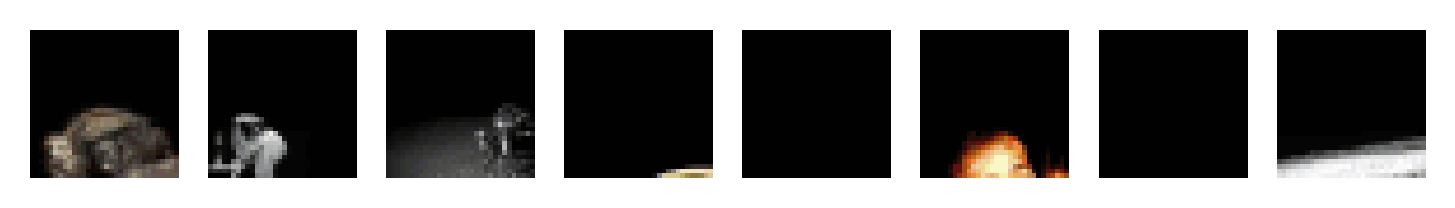

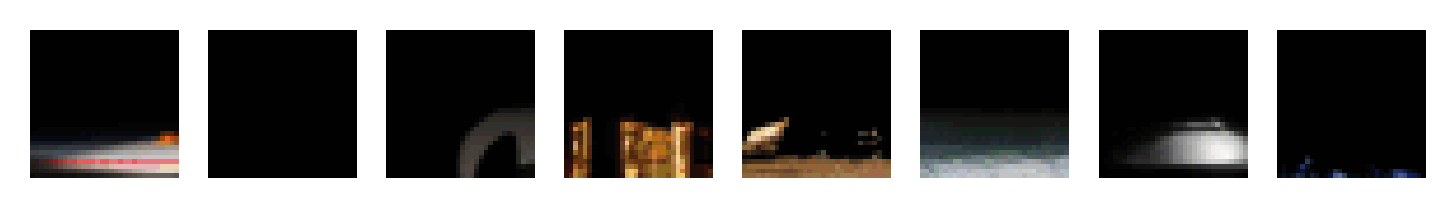

In [ ]:
  x = np.zeros((bs,n_px,n_px,3),dtype=np.uint8)
image_gpt_process(x, ntimes=2)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


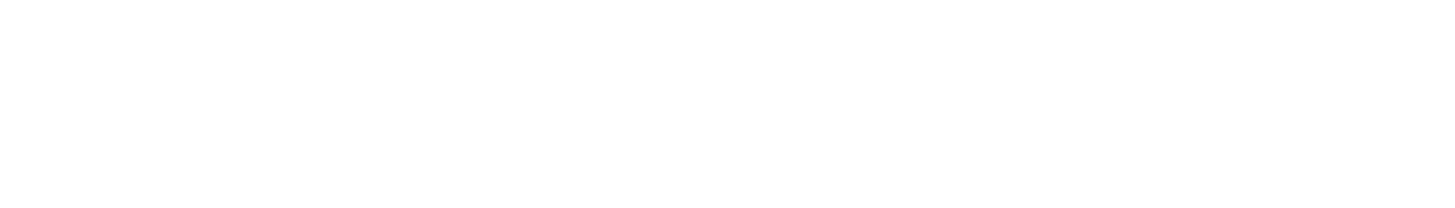

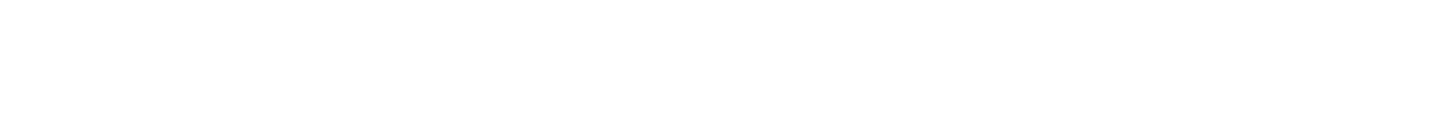

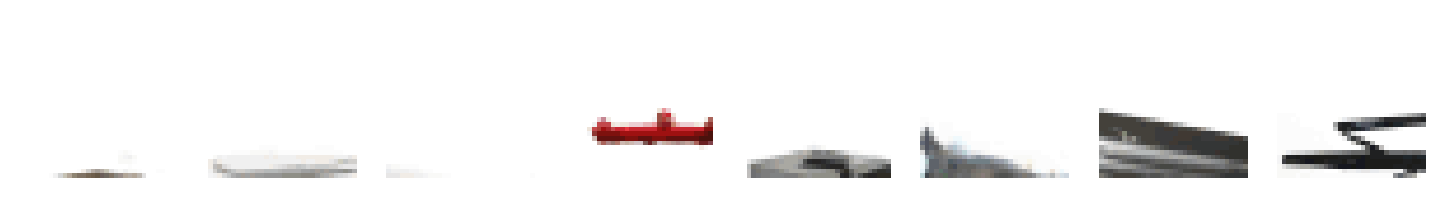

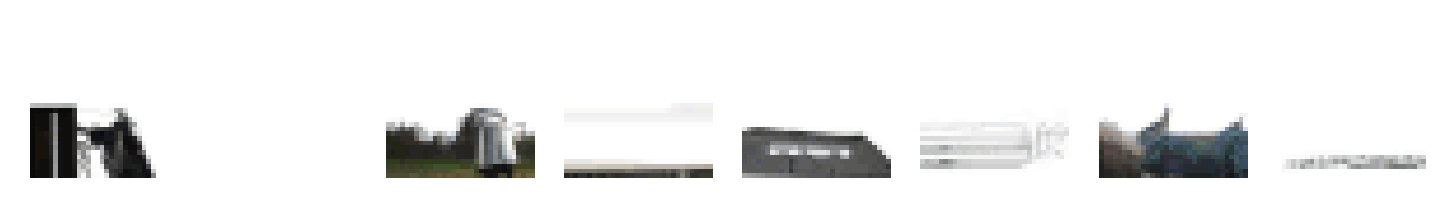

In [ ]:
x = np.zeros((bs,n_px,n_px,3),dtype=np.uint8)
x[:,:] = 255
image_gpt_process(x, ntimes=2)

In [ ]:
#get images
!curl https://t3.ftcdn.net/jpg/02/17/59/56/360_F_217595684_yrZJY0XicILFmx9pemitaK061gbPovad.jpg > ms.jpeg
image_paths = ["ms.jpeg"]*bs

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46961  100 46961    0     0  1479k      0 --:--:-- --:--:-- --:--:-- 1479k


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


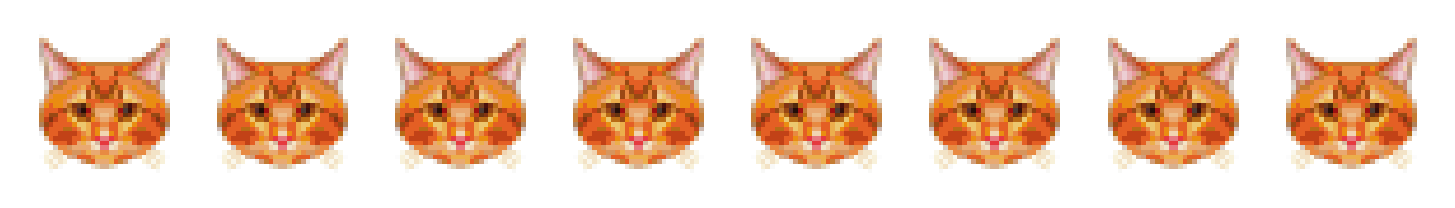

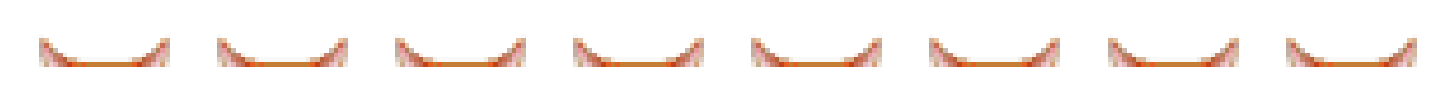

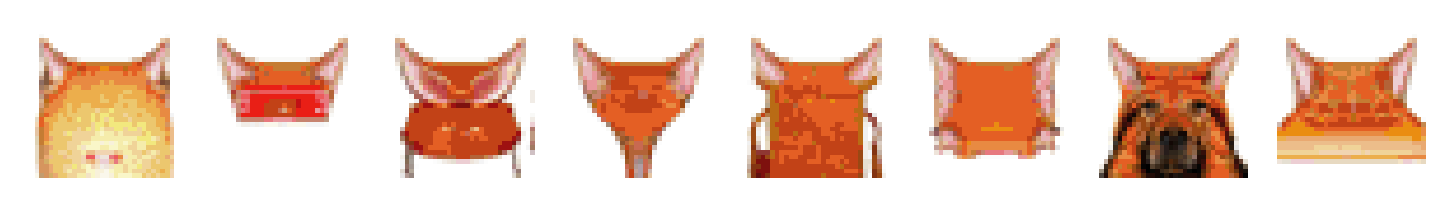

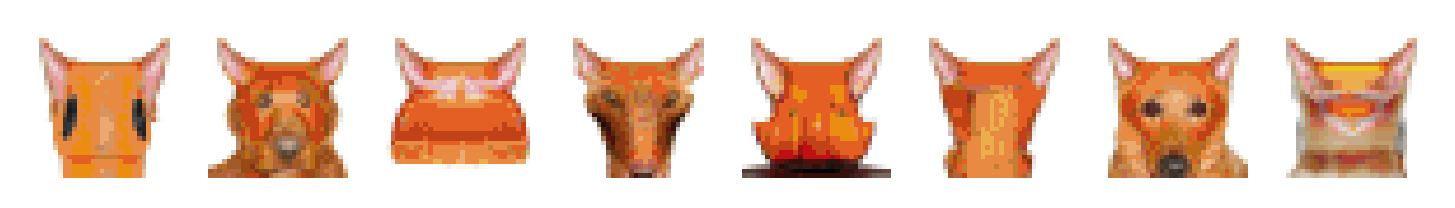

In [ ]:
x = np.zeros((bs,n_px,n_px,3),dtype=np.uint8)

for n,image_path in enumerate(image_paths):
  img_np = cv2.imread(image_path)   # reads an image in the BGR format
  img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)   # BGR -> RGB
  H,W,C = img_np.shape
  D = min(H,W)
  img_np = img_np[:D,:D,:C] #get square piece of image
  x[n] = cv2.resize(img_np,dim, interpolation = cv2.INTER_AREA) #resize to n_px by n_px

image_gpt_process(x, ntimes=2,n_px_crop=8)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


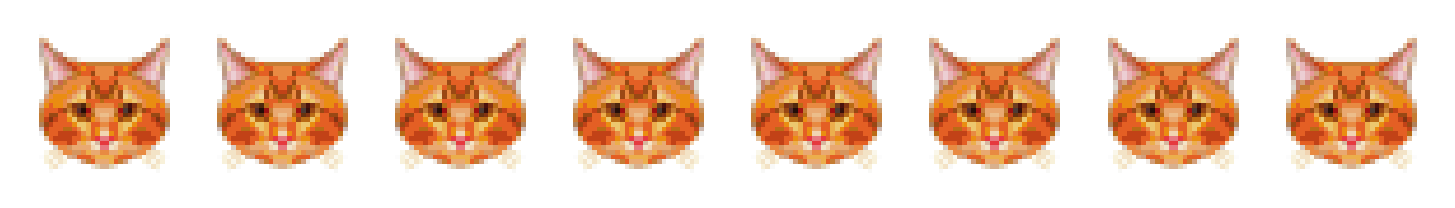

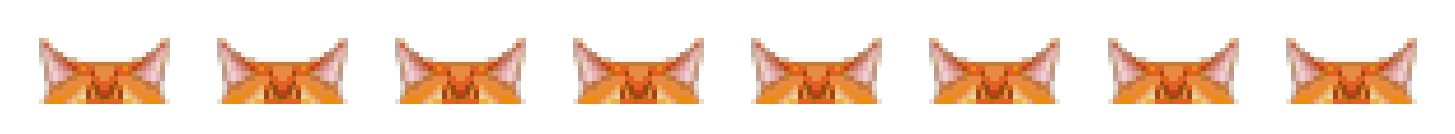

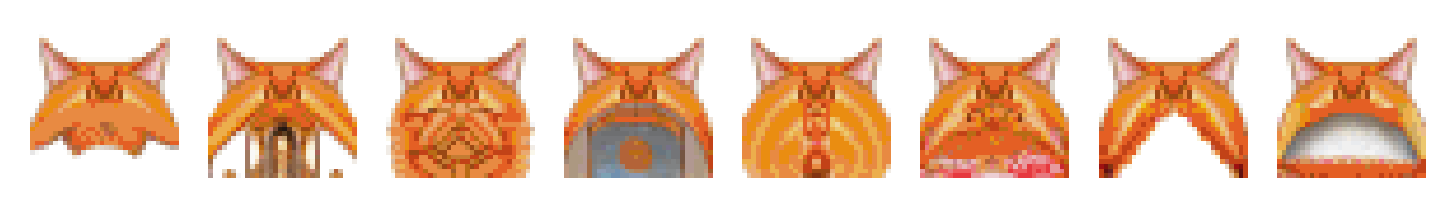

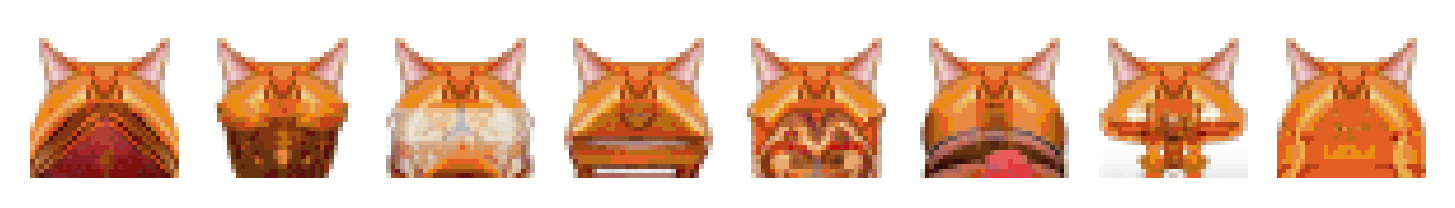

In [ ]:
image_gpt_process(x, ntimes=2,n_px_crop=16)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


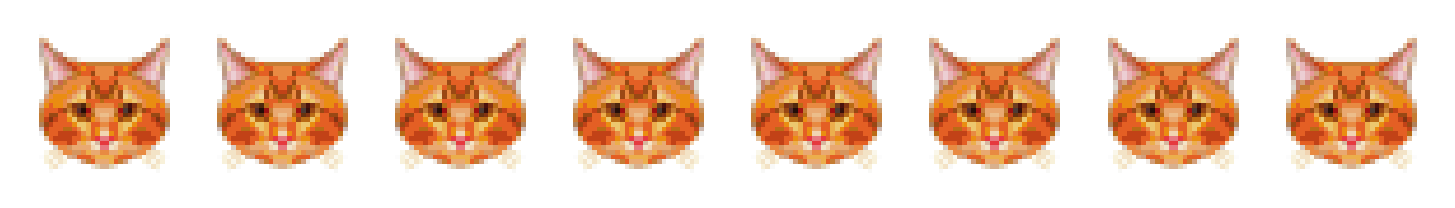

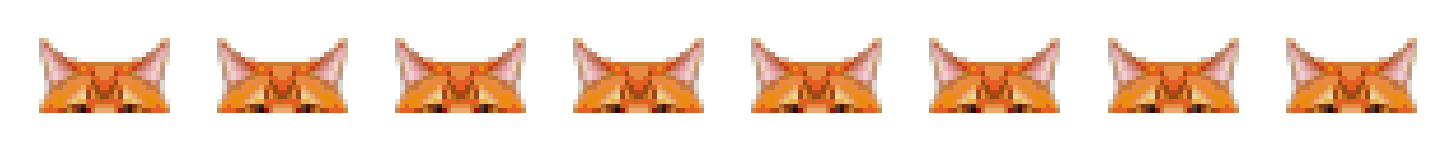

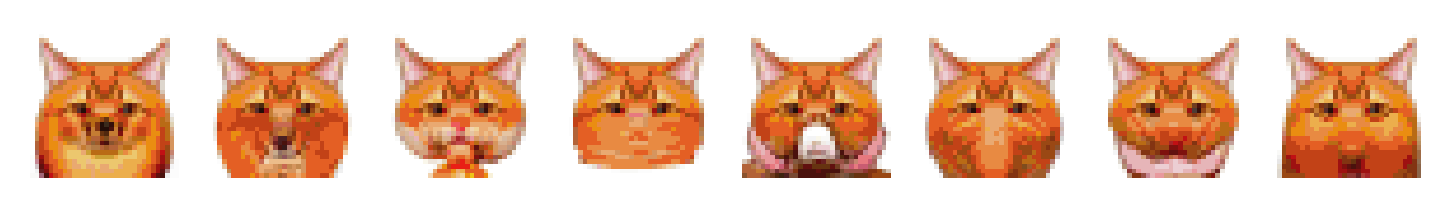

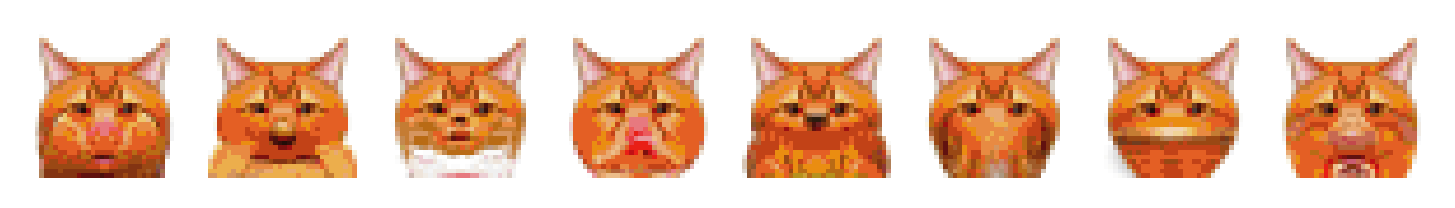

In [ ]:

image_gpt_process(x, ntimes=2,n_px_crop=18)

In [ ]:
#get images
!curl http://www.sweethome3d.com/textures/eteks-scopia/vertical_blue_lines.png > img.png
img_np0 = cv2.imread("img.png")[0:32,0:32,:] 
print(img_np0.shape)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2080  100  2080    0     0   4952      0 --:--:-- --:--:-- --:--:--  4940
(32, 32, 3)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


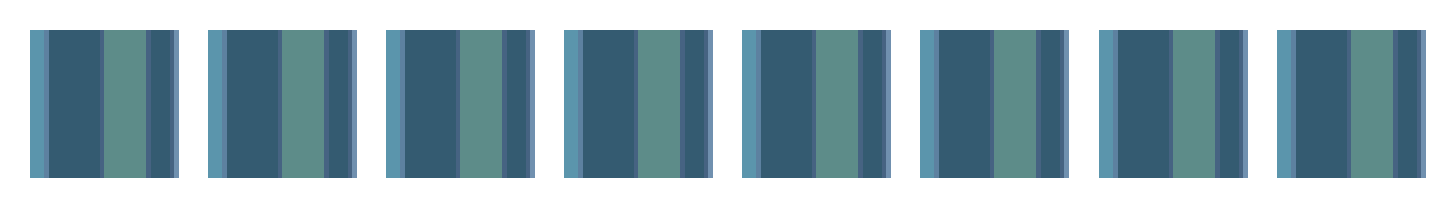

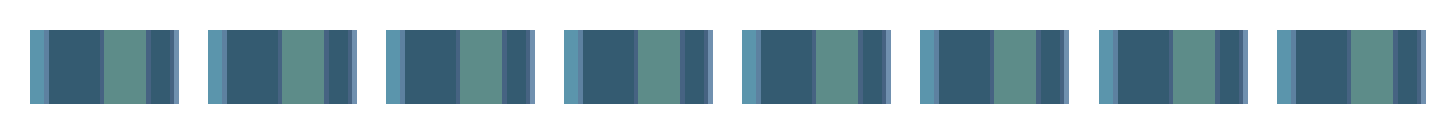

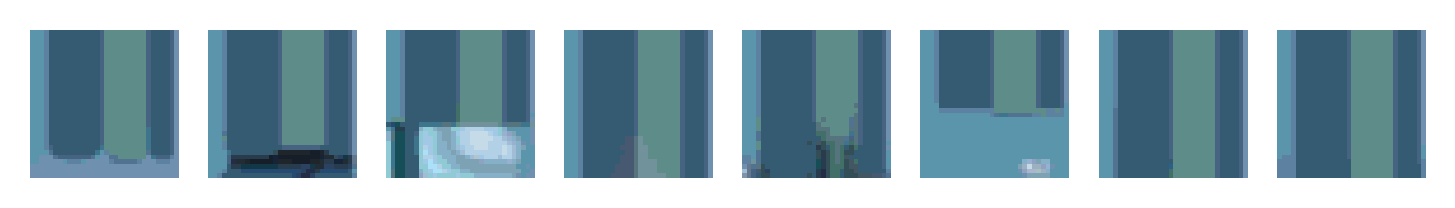

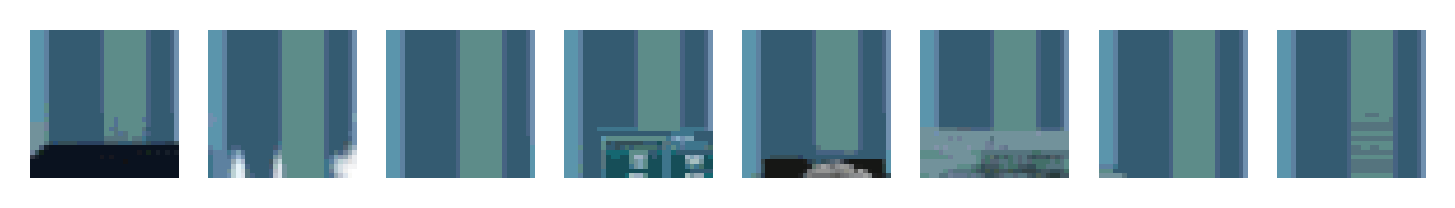

In [ ]:
x = np.zeros((bs,n_px,n_px,3),dtype=np.uint8)

for n,image_path in enumerate(image_paths): # reads an image in the BGR format
  img_np = cv2.cvtColor(img_np0, cv2.COLOR_BGR2RGB)   # BGR -> RGB
  H,W,C = img_np.shape
  D = min(H,W)
  img_np = img_np[:D,:D,:C] #get square piece of image
  x[n] = cv2.resize(img_np,dim, interpolation = cv2.INTER_AREA) #resize to n_px by n_px

image_gpt_process(x, ntimes=2,n_px_crop=16)